In [1]:
import cv2 as cv
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

In [2]:
HEIGHT = 400
WIDTH = 400

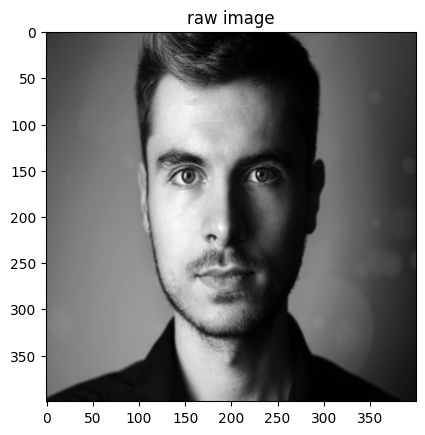

image shape (400, 400)


In [3]:
filename = "./face.jpg"
image = None
if os.path.exists(filename):
    image = cv.imread(filename,0)
    image = cv.resize(image,(400, 400), interpolation = cv.INTER_AREA)
    plt.imshow(image,"gray")
    plt.title("raw image")
    plt.show()
    print(f"image shape {image.shape}")
else:
    print(f"{filename} doesn't exist")

<Figure size 1600x1600 with 0 Axes>

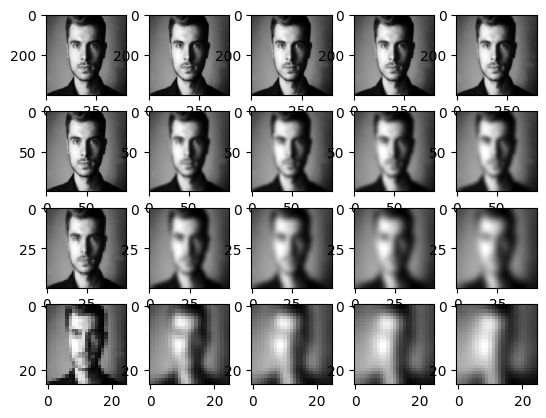

In [24]:
octaves_blurs = []
plt.figure(figsize = (16,16))
fig, axs = plt.subplots(4,5)
temp = image.copy()
height, width = temp.shape
for octave in range(4):
    if octave != 0:
        height = height // 2
        width = width // 2
        temp = cv.resize(temp,(width//2, height//2), interpolation = cv.INTER_AREA)
    octaves_blurs.append(temp)
    axs[octave,0].imshow(temp,"gray")
    blur_image = temp.copy()
    for blur_i in range(1,5):
        blur_image = cv.GaussianBlur(blur_image,(5,5),0)
        axs[octave,blur_i].imshow(blur_image,"gray")
        octaves_blurs.append(blur_image)
plt.show()

<Figure size 1600x1600 with 0 Axes>

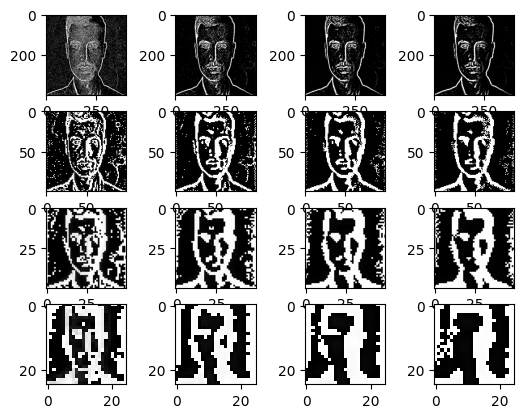

In [25]:
plt.figure(figsize = (16,16))
fig, axs = plt.subplots(4,4)
#compute DOG for each octave
dogs = []
idx = -1
count = -1
for i in range(0,len(octaves_blurs)):
    if i % 5 == 0:
        pass
        idx += 1
        count = 0
    else:
        temp = octaves_blurs[i-1] - octaves_blurs[i]
        axs[idx,count].imshow(temp,"gray")
        dogs.append(temp)
        count += 1
plt.show()

In [7]:
#extracting key points
def get_neightbors(cx,cy,cur,prev=None,nex=None):
    """
    return all 9 pixels in the prev and next (18 total), along with 8 neighbors
    in the current image
    """
    res = []
    if prev is not None:
        res.extend( prev[cy-1:cy+2,cx-1:cx+2].reshape(-1))
    if nex is not None:
        res.extend( nex[cy-1:cy+2,cx-1:cx+2].reshape(-1) )
    height, width = cur.shape
    for y in range(-1,2):
        for x in range(-1,2):
            if y != 0 and x != 0:
                if 0 <= y+cy <= height-1 and 0 <= x+cx <= width-1:
                    res.append(cur[y+cy,x+cx])
    return res
        

In [31]:
keypoints = []

def compute_taylor_expansion(image, keypoint):
    # Extract the coordinates of the keypoint
    x, y = keypoint[0], keypoint[1]
    
    # Compute second-order Taylor expansion
    dx = (image[y, x + 1] - image[y, x - 1]) / 2
    dy = (image[y + 1, x] - image[y - 1, x]) / 2
    dxx = image[y, x + 1] - 2 * image[y, x] + image[y, x - 1]
    dyy = image[y + 1, x] - 2 * image[y, x] + image[y - 1, x]
    
    # Calculate the resulting value of the Taylor expansion
    taylor_value = dx + dy + dxx + dyy
    
    return taylor_value

def reject_low_contrast_keypoints(keypoints, image):
    threshold = 0.03
    selected_keypoints = []
    height, width = image.shape
    
    for keypoint in keypoints:
        x,y = keypoint
        if x == 0 or y == 0 or x == width-1 or y == height-1:
            continue
        taylor_value = compute_taylor_expansion(image, keypoint)
        
        # Check if the taylor_value is above the threshold
        if abs(taylor_value) >= threshold:
            selected_keypoints.append(keypoint)
    
    return selected_keypoints

def get_keyPoint(octaves_dogs):
    """
    dogs images for the one layer of octave
    """
    keypoints = {}
    height, width = octaves_dogs[0].shape
    numsPixel = height*width
    for i,dog in enumerate(octaves_dogs):
        if i == 0:
            prev_d = None
            nex_d = octaves_dogs[i+1]
            # first image, only current octave
        elif i == len(octaves_dogs)-1:
            #last image
            nex_d = None
            prev_d = octaves_dogs[i-1]
        
        rawKeyPoints = []
        for y in range(height):
            for x in range(width):
                pixel = image[y,x]
                neightbors = get_neightbors(x,y,dog,prev= prev_d, nex= nex_d)
                if pixel > max(neightbors) or pixel < min(neightbors):
                    rawKeyPoints.append((x,y))
        high_contrast_keyPoints = reject_low_contrast_keypoints(rawKeyPoints, dog)
        print(f"  nums rawPoints {len(rawKeyPoints)} {len(rawKeyPoints) / numsPixel:.2f}\n  nums high_contrast {len(high_contrast_keyPoints)} {len(high_contrast_keyPoints) / numsPixel:.2f}")
        keypoints[i] = (high_contrast_keyPoints)
        
    return keypoints
 
keyPoints = get_keyPoint(dogs[:4])

/var/folders/zs/zrwdvjjn551661ft74skt2jh0000gn/T/ipykernel_45320/526830091.py:9: RuntimeWarning: overflow encountered in scalar subtract
  dy = (image[y + 1, x] - image[y - 1, x]) / 2
/var/folders/zs/zrwdvjjn551661ft74skt2jh0000gn/T/ipykernel_45320/526830091.py:8: RuntimeWarning: overflow encountered in scalar subtract
  dx = (image[y, x + 1] - image[y, x - 1]) / 2


  nums rawPoints 77628 0.49
  nums high_contrast 45771 0.29
  nums rawPoints 118201 0.74
  nums high_contrast 25369 0.16
  nums rawPoints 114855 0.72
  nums high_contrast 21099 0.13
  nums rawPoints 125829 0.79
  nums high_contrast 22828 0.14


In [35]:
dogs[1]

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0, 255, 254, ...,   0,   0,   0],
       [255, 254, 254, ...,   0,   0,   0],
       [254, 253, 254, ...,   0,   0,   0]], dtype=uint8)

<Figure size 1600x1600 with 0 Axes>

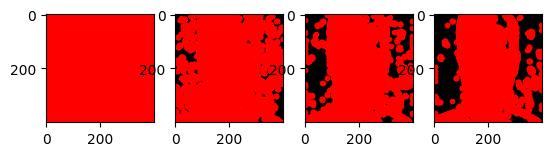

In [34]:
plt.figure(figsize = (16,16))
fig, axs = plt.subplots(1,4)
for i in range(4):
    axs[i].imshow(dogs[i],"gray")
    key_points = keyPoints[i]
    x,y = map(list, zip(*key_points))
    axs[i].plot(x,y,'r.')
plt.show()

In [33]:
plt.plot?